## Import

In [1]:
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torchdata
from torchvision.transforms import transforms
from torchinfo import summary

In [2]:
import netCDF4 as nc
import seaborn.colors.xkcd_rgb as c

## Utilities

In [3]:
def set_seed(myseed:int):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(myseed)
    torch.manual_seed(myseed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(myseed)
    # Check
    print("===Testing random seeds===")
    print("Current seed:", myseed)
    print("Random value from torch:", torch.rand(1).item(), " -> should be 0.8822692632675171 for seed=42")
    print("Random value from numpy:", np.random.rand(1)[0], " -> should be 0.3745401188473625 for seed=42")
    print("==========================")

In [4]:
set_seed(42)

===Testing random seeds===
Current seed: 42
Random value from torch: 0.8822692632675171  -> should be 0.8822692632675171 for seed=42
Random value from numpy: 0.3745401188473625  -> should be 0.3745401188473625 for seed=42


In [5]:
def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
lu_list       = ['bu', 'eb', 'eu', 'gb', 'ge', 'gp', 'gu', 'pb', 'pe', 'pu']

## Data

In [7]:
class PBLDataset():
    def __init__(self, lu:str, proportion_list:list, jump_time:int=1):
        self.lu          = lu         # land type
        self.jump_time   = jump_time  # mapped adjustment time interval, defautl=1
        self.propo_list  = proportion_list  # train/(val)/test proportion

        self.day_num     = 3
        self.ts_cover    = (0, 391+self.jump_time)  # 5:00 - 18:00 + jump time
        self.ts_state_1d = (0, 391)                 # state (input) time cover, 1 day
        
        # Read data into numpy arrays (tsteps, var, lev)
        ncs1 = nc.Dataset(f'/home/ch995334/2024ClDyn/TemporaryData/lu_profs/{lu}_1p0km.nc')
        ncs2 = nc.Dataset(f'/home/ch995334/2024ClDyn/TemporaryData/lu_profs/{lu}_1p5km.nc')
        ncs3 = nc.Dataset(f'/home/ch995334/2024ClDyn/TemporaryData/lu_profs/{lu}_2p0km.nc')
        th_all_sd = np.concatenate((ncs1.variables['th'][:self.ts_state_1d[1], :].data, 
                                    ncs2.variables['th'][:self.ts_state_1d[1], :].data, 
                                    ncs3.variables['th'][:self.ts_state_1d[1], :].data), axis=0)
        self.th_all_sd = th_all_sd
        th_diff_all_sd = np.concatenate((ncs1.variables['th'][self.jump_time:self.ts_cover[1], :].data-ncs1.variables['th'][:self.ts_state_1d[1], :].data, 
                                         ncs2.variables['th'][self.jump_time:self.ts_cover[1], :].data-ncs2.variables['th'][:self.ts_state_1d[1], :].data, 
                                         ncs3.variables['th'][self.jump_time:self.ts_cover[1], :].data-ncs3.variables['th'][:self.ts_state_1d[1], :].data), axis=0)
        # Shuffle-split index (the given proportion should be applied to all soundings)
        subset_idx   = []
        for d in range(self.day_num):
            day_idx = np.arange(self.ts_state_1d[1]*(d), self.ts_state_1d[1]*(d+1))
            np.random.shuffle(day_idx)
            if d == 0:
                subset_idx = np.split(day_idx, np.cumsum((np.array(self.propo_list)*day_idx.shape[0])[:-1]).astype(int))
            else:
                temp       = np.split(day_idx, np.cumsum((np.array(self.propo_list)*day_idx.shape[0])[:-1]).astype(int))
                for i in range(len(self.propo_list)):
                    subset_idx[i] = np.append(subset_idx[i], temp[i])
        self.subset_idx= tuple(subset_idx)
        # Normalization (whole-set), save Input and Target scalars
        self.th_min, self.th_max           = np.min(th_all_sd), np.max(th_all_sd)
        self.th_diff_min, self.th_diff_max = np.min(th_diff_all_sd), np.max(th_diff_all_sd)
        th_norm      = (th_all_sd-self.th_min)/(self.th_max-self.th_min)
        th_diff_norm = (th_diff_all_sd-self.th_diff_min)/(self.th_diff_max-self.th_diff_min)
        
        # Create data tensor and dataset
        if len(self.propo_list) == 3:
            TrainIdx,   ValIdx,   TestIdx   = self.subset_idx
            self.InputTrain, self.InputVal, self.InputTest = torch.FloatTensor(th_norm[TrainIdx, np.newaxis, :]),\
                                                             torch.FloatTensor(th_norm[ValIdx, np.newaxis, :]),\
                                                             torch.FloatTensor(th_norm[TestIdx, np.newaxis, :])
            self.TargetTrain,self.TargetVal,self.TargetTest= torch.FloatTensor(th_diff_norm[TrainIdx, :]),\
                                                             torch.FloatTensor(th_diff_norm[ValIdx, :]),\
                                                             torch.FloatTensor(th_diff_norm[TestIdx, :])
            
            self.TrainDataset = torchdata.TensorDataset(self.InputTrain, self.TargetTrain)
            self.ValDataset   = torchdata.TensorDataset(self.InputVal, self.TargetVal)
            self.TestDataset  = torchdata.TensorDataset(self.InputTest, self.TargetTest)
        elif len(self.propo_list) == 2:
            TrainIdx,   TestIdx   = self.subset_idx
            self.InputTrain, self.InputTest = torch.FloatTensor(th_norm[TrainIdx, np.newaxis, :]),\
                                              torch.FloatTensor(th_norm[TestIdx, np.newaxis, :])
            self.TargetTrain,self.TargetTest= torch.FloatTensor(th_diff_norm[TrainIdx, :]),\
                                              torch.FloatTensor(th_diff_norm[TestIdx, :])
            
            self.TrainDataset = torchdata.TensorDataset(self.InputTrain, self.TargetTrain)
            self.TestDataset  = torchdata.TensorDataset(self.InputTest, self.TargetTest)
        print(f"Finished creating the PBL dataset for land type {lu.upper()}.")
        print(f"Current input:  theta state profile")
        print(f"Current target: theta adjustemnt with jump-time = {self.jump_time}")

## NN Model

### Model structure

In [8]:
class CNN1D(nn.Module):
    def __init__(self, input_var_num:int):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_var_num, out_channels=16, kernel_size=3, stride=1) # no padding, -2
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1)  # no padding, -2
        self.fc1 = nn.Linear(32*71, 64)  # 71 = 75-2-2
        self.fc2 = nn.Linear(64, 75)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_demo = CNN1D(input_var_num=1)
summary(model_demo, input_size=(32,1,75), device="cuda")

Layer (type:depth-idx)                   Output Shape              Param #
CNN1D                                    [32, 75]                  --
├─Conv1d: 1-1                            [32, 16, 73]              64
├─ReLU: 1-2                              [32, 16, 73]              --
├─Conv1d: 1-3                            [32, 32, 71]              1,568
├─ReLU: 1-4                              [32, 32, 71]              --
├─Flatten: 1-5                           [32, 2272]                --
├─Linear: 1-6                            [32, 64]                  145,472
├─ReLU: 1-7                              [32, 64]                  --
├─Linear: 1-8                            [32, 75]                  4,875
Total params: 151,979
Trainable params: 151,979
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 8.52
Input size (MB): 0.01
Forward/backward pass size (MB): 0.92
Params size (MB): 0.61
Estimated Total Size (MB): 1.53

### Training func

In [9]:
def train(model_to_train, train_loader, val_loader, config:dict, device):
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = getattr(torch.optim, config['optimizer'])(model_to_train.parameters(), **config['optim_hparas'])
    # Training loop
    loss_log  = {'train':[], 'val':[]}
    for epoch in range(config['epochs']):
        model_to_train.train()
        train_loss  = 0
        for inputs, targets in train_loader:   # batch = (inputs, targets)
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.float)
            optimizer.zero_grad()
            outputs = model_to_train(inputs)
            loss    = criterion(outputs, targets)
            loss.backward()    # back propagate gradient
            optimizer.step()   # update model with opitmizer
            train_loss += loss.item()
        loss_log['train'].append(train_loss / len(train_loader))  # loss averaged over batches

        # Validation
        model_to_train.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.float)
                outputs = model_to_train(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        loss_log['val'].append(val_loss/len(val_loader))
        # Print loss on screen
        if epoch%10 == 0:
            print(f"Epoch {epoch + 1}/{config['epochs']}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")
    return model_to_train, loss_log

### Prediction func

In [10]:
def predict(trained_model, test_loader, device):
    # Get prediction
    trained_model.eval()
    counter = 0
    with torch.no_grad():                     # disable gradient descend
        for batch in test_loader:
            if len(batch) == 2:
                inputs, targets = batch
            elif len(batch) == 1:
                inputs = batch[0]
            inputs = inputs.to(device, dtype=torch.float)
            pred   = trained_model(inputs)
            if counter < 1:
                preds = pred.detach().cpu().numpy()
                print(preds.shape)
            else:
                preds = np.concatenate((preds, pred.detach().cpu().numpy()), axis=0)
            counter += 1
    return preds

### Save and Load models

In [11]:
def save_model(model, savepath:str):
    model.eval()
    torch.save(model.state_dict(), f"{savepath}_state.pt")

In [12]:
def load_model(model_instance, savepath:str):
    """
    `model_instance` should be the exact same in structure with what this function is loading.
    """
    model_instance.load_state_dict(torch.load(f"{savepath}_state.pt", weights_only=True))
    return model_instance

## Main

### Setup hparams config

In [13]:
config = {'epochs':200, 
          'batch_size':32, 
          'optimizer':'Adam', 
          'optim_hparas':{'lr':0.001}}

In [14]:
device = get_device()
print(device)

cuda


### Generate data

In [15]:
def GenerateData(lu:str, proportion_list:list, jump_time:int=1):
    import datetime
    # Empty data
    data_dict = {}
    data_dict['info'] = {'generation time':datetime.datetime.now()}
    # Set seed
    myseed    = 42
    set_seed(myseed)
    data_dict['seed'] = myseed
    # Initiate data class
    case_data = PBLDataset(lu, proportion_list, jump_time)
    data_dict['subset_idx'] = case_data.subset_idx
    if len(proportion_list) == 2:
        data_dict['InputTrain'], data_dict['InputTest'] = case_data.InputTrain, case_data.InputTest
        data_dict['TargetTrain'], data_dict['TargetTest'] = case_data.TargetTrain, case_data.TargetTest
        data_dict['TrainDataset'], data_dict['TestDataset'] = case_data.TrainDataset, case_data.TestDataset
    elif len(proportion_list) == 3:
        data_dict['InputTrain'], data_dict['InputVal'], data_dict['InputTest'] = case_data.InputTrain, case_data.InputVal, case_data.InputTest
        data_dict['TargetTrain'], data_dict['TargetVal'], data_dict['TargetTest'] = case_data.TargetTrain, case_data.TargetVal, case_data.TargetTest
        data_dict['TrainDataset'], data_dict['ValDataset'], data_dict['TestDataset'] = case_data.TrainDataset, case_data.ValDataset, case_data.TestDataset
    data_dict['th_max'], data_dict['th_min'] = case_data.th_max, case_data.th_min
    data_dict['th_diff_max'], data_dict['th_diff_min'] = case_data.th_diff_max, case_data.th_diff_min
    data_dict['th_all_sd'] = case_data.th_all_sd
    # Save data dict
    np.save(f'/home/ch995334/2024ClDyn/TemporaryData/ModelData/all_lu_cnn1/{lu}.npy', data_dict)
    print('==========================')
    print(f'Finished saving data for model training for land type {lu.upper()}.')

In [83]:
props = [0.8, 0.2]
for lu in lu_list:
    GenerateData(lu=lu, proportion_list=props)

===Testing random seeds===
Current seed: 42
Random value from torch: 0.8822692632675171  -> should be 0.8822692632675171 for seed=42
Random value from numpy: 0.3745401188473625  -> should be 0.3745401188473625 for seed=42
Finished creating the PBL dataset for land type BU.
Current input:  theta state profile
Current target: theta adjustemnt with jump-time = 1
Finished saving data for model training for land type BU.
===Testing random seeds===
Current seed: 42
Random value from torch: 0.8822692632675171  -> should be 0.8822692632675171 for seed=42
Random value from numpy: 0.3745401188473625  -> should be 0.3745401188473625 for seed=42
Finished creating the PBL dataset for land type EB.
Current input:  theta state profile
Current target: theta adjustemnt with jump-time = 1
Finished saving data for model training for land type EB.
===Testing random seeds===
Current seed: 42
Random value from torch: 0.8822692632675171  -> should be 0.8822692632675171 for seed=42
Random value from numpy: 0.

### Start Training!

In [16]:
def main(lu:str):
    # Set seed
    set_seed(42)
    # Load data
    data_dict    = np.load(f'/home/ch995334/2024ClDyn/TemporaryData/ModelData/all_lu_cnn1/{lu}.npy', allow_pickle=True).item()
    train_loader = torchdata.DataLoader(data_dict['TrainDataset'], batch_size=config['batch_size'])
    test_loader  = torchdata.DataLoader(data_dict['TestDataset'], batch_size=1)
    # Initialize model
    model_init = CNN1D(input_var_num=1).to(device)
    # Training
    trained_model, loss_log = train(model_init, train_loader, test_loader, config, device)
    trained_model.eval()
    prediction   = predict(trained_model, test_loader, device)
    nn_dict      = {'trained_model':trained_model, 'loss_log':loss_log, 'prediction':prediction}
    return nn_dict

In [18]:
nn_dict_all_lu = dict(zip(lu_list, [[] for i in range(len(lu_list))]))
for lu in lu_list:
    print("==========================")
    print(f"Training for land type {lu.upper()} starts.")
    nn_dict_all_lu[lu] = main(lu=lu)
    print(f"Training for land type {lu.upper()} finished.")

Training for land type BU starts.
===Testing random seeds===
Current seed: 42
Random value from torch: 0.8822692632675171  -> should be 0.8822692632675171 for seed=42
Random value from numpy: 0.3745401188473625  -> should be 0.3745401188473625 for seed=42
Epoch 1/200, Train Loss: 0.0423, Val Loss: 0.0099
Epoch 11/200, Train Loss: 0.0047, Val Loss: 0.0050
Epoch 21/200, Train Loss: 0.0025, Val Loss: 0.0026
Epoch 31/200, Train Loss: 0.0019, Val Loss: 0.0021
Epoch 41/200, Train Loss: 0.0028, Val Loss: 0.0024
Epoch 51/200, Train Loss: 0.0025, Val Loss: 0.0036
Epoch 61/200, Train Loss: 0.0019, Val Loss: 0.0023
Epoch 71/200, Train Loss: 0.0024, Val Loss: 0.0023
Epoch 81/200, Train Loss: 0.0022, Val Loss: 0.0025
Epoch 91/200, Train Loss: 0.0010, Val Loss: 0.0010
Epoch 101/200, Train Loss: 0.0008, Val Loss: 0.0009
Epoch 111/200, Train Loss: 0.0008, Val Loss: 0.0010
Epoch 121/200, Train Loss: 0.0008, Val Loss: 0.0009
Epoch 131/200, Train Loss: 0.0007, Val Loss: 0.0007
Epoch 141/200, Train Loss: 

(Optional) Save trained model

In [ ]:
save_model(trained_model, savepath=)
del trained_model

## Post Analyses

### Pattern correlation

In [24]:
def cal_patt_corr(array1:np.ndarray, array2:np.ndarray):
    if array1.shape[0] < 2:
        correlation_matrix = np.corrcoef(array1, array2)
        coef = correlation_matrix[0, 1]
    else:
        coef = []
        for i in range(array1.shape[0]):
            correlation_matrix = np.corrcoef(array1[i, :], array2[i, :])
            coef.append(correlation_matrix[0, 1])
        coef = np.array(coef)
    return coef

In [35]:
def Plot_lu_metrics_box(lu_metrics_dict:dict, figpath:str=False):
    """
    lu_metrics_dict should be a dictionary storing the same metrics from different landtypes.
    """
    # Get the median of all landtype medians
    # all_medians = []
    # for patt_corr in lu_metrics_dict.values():
    #     all_medians.append(np.median(patt_corr))
    # all_medians = np.array(all_medians)
    # median_lu   = np.median(all_medians)
    
    # Get the median of all landtype mins
    all_Q1 = []
    for patt_corr in lu_metrics_dict.values():
        all_Q1.append(np.percentile(patt_corr, 25))
    all_Q1 = np.array(all_Q1)
    median_lu   = np.median(all_Q1)
    # Landtypes
    lu_list = list(lu_metrics_dict.keys())   # ['OU', 'GU', 'PU', 'EU', 'OG', 'OE', 'OP', 'PG', 'GE', 'PE']
    # Box settings
    boxprops_top5 = dict(linestyle='-', linewidth=4, color=c['cherry'])
    boxprops_low5 = dict(linestyle='-', linewidth=4, color=c['azure'])
    medianprops   = dict(linestyle='-', linewidth=4, color='k')
    # Plot 
    fig, ax = plt.subplots(figsize=(12, 6))
    for i, lu in enumerate(lu_list):
        if all_Q1[i]>=median_lu:
            ax.boxplot(lu_metrics_dict[lu.lower()], positions=np.array([len(lu_list)-i]), tick_labels=[lu], 
                       showfliers=False, widths=.4, boxprops=boxprops_top5, medianprops=medianprops)
        else:
            ax.boxplot(lu_metrics_dict[lu.lower()], positions=np.array([len(lu_list)-i]), tick_labels=[lu], 
                       showfliers=False, widths=.4, boxprops=boxprops_low5, medianprops=medianprops)
    ax.grid(linestyle=':', linewidth=0.5, color='grey')
    ax.set_ylim([0., 1])
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 0.9, 1.0])
    ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 0.9, 1.0], fontsize=14)
    ax.set_xticklabels([f"{lu.upper()}" for lu in lu_list], fontsize=14)
    ax.set_title(r'$\Delta \theta$ Profile Correlation Distribution', fontweight='bold', fontsize=18)
    if figpath:
        plt.savefig(f'/home/ch995334/2024ClDyn/Figure/Final/box_{figpath}.png', bbox_inches='tight', facecolor='w', dpi=400)
    else:
        plt.show()

In [26]:
dict_patt_corr_lu = dict(zip(lu_list, [[] for i in range(len(lu_list))]))
for i, lu in enumerate(lu_list):
    nn_dict = nn_dict_all_lu[lu]
    lu_data_dict = np.load(f'/home/ch995334/2024ClDyn/TemporaryData/ModelData/all_lu_cnn1/{lu}.npy', allow_pickle=True).item()
    lu_ytest= lu_data_dict['TargetTest']
    y_test, pred   = lu_ytest, nn_dict['prediction']
    dict_patt_corr_lu[lu] = cal_patt_corr(y_test, pred)

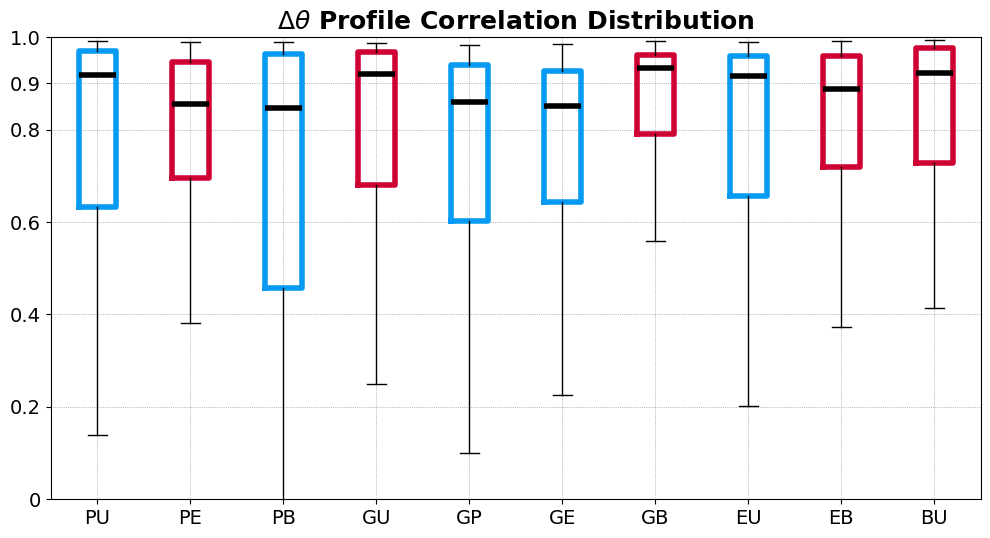

In [36]:
Plot_lu_metrics_box(dict_patt_corr_lu)

## Test

### Thoughts dump

In [10]:
getattr(torch.optim, 'Adam')

torch.optim.adam.Adam

In [29]:
a = np.arange(10)
np.random.shuffle(a)

In [32]:
np.split(a, np.cumsum((np.array([0.8, 0.2])*a.shape[0])[:-1]).astype(int))
# np.split(day_idx, np.cumsum((np.array(self.propo_list)*day_idx.shape[0])[:-1]).astype(int))

[array([2, 9, 0, 7, 4, 6, 1, 5]), array([8, 3])]

In [33]:
np.append(np.arange(5), np.ones(4))

array([0., 1., 2., 3., 4., 1., 1., 1., 1.])

### Dataset Class

In [41]:
ds_class_temp = PBLDataset(lu='pb', proportion_list=[0.8, 0.2])

Finished creating the PBL dataset for land type PB.
Current input:  theta state profile
Current target: theta adjustemnt with jump-time = 1


In [38]:
ds_class_temp.TrainDataset

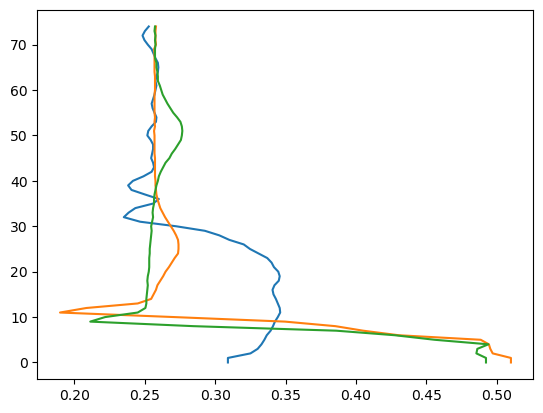

In [13]:
plt.plot(ds_class_temp.TargetTest[5, 0, :], np.arange(75))
plt.plot(ds_class_temp.TargetTest[35, 0, :], np.arange(75))
plt.plot(ds_class_temp.TargetTest[200, 0, :], np.arange(75))

In [78]:
ds_class_temp.InputTrain.shape

torch.Size([936, 1, 75])

### Prediction peek

In [19]:
bu_pred = nn_dict_all_lu['bu']['prediction']
bu_data_dict = np.load('/home/ch995334/2024ClDyn/TemporaryData/ModelData/all_lu_cnn1/bu.npy', allow_pickle=True).item()
bu_ytest= bu_data_dict['TargetTest']

In [20]:
bu_ytest.shape

torch.Size([237, 75])

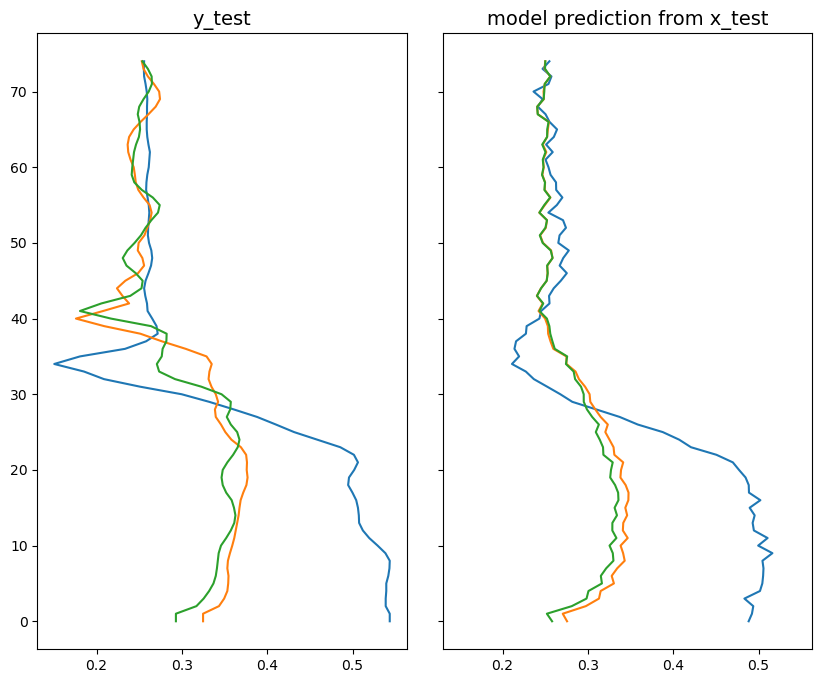

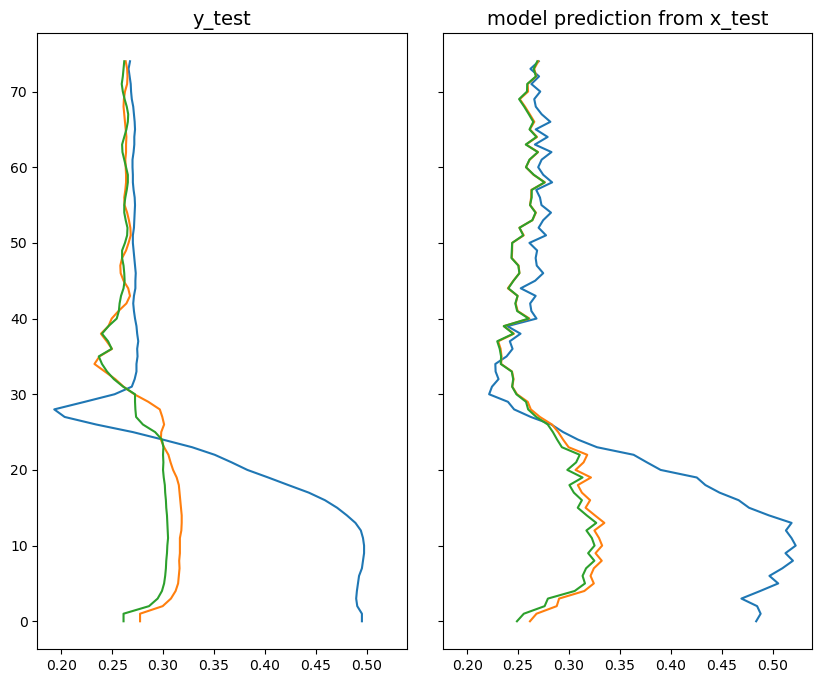

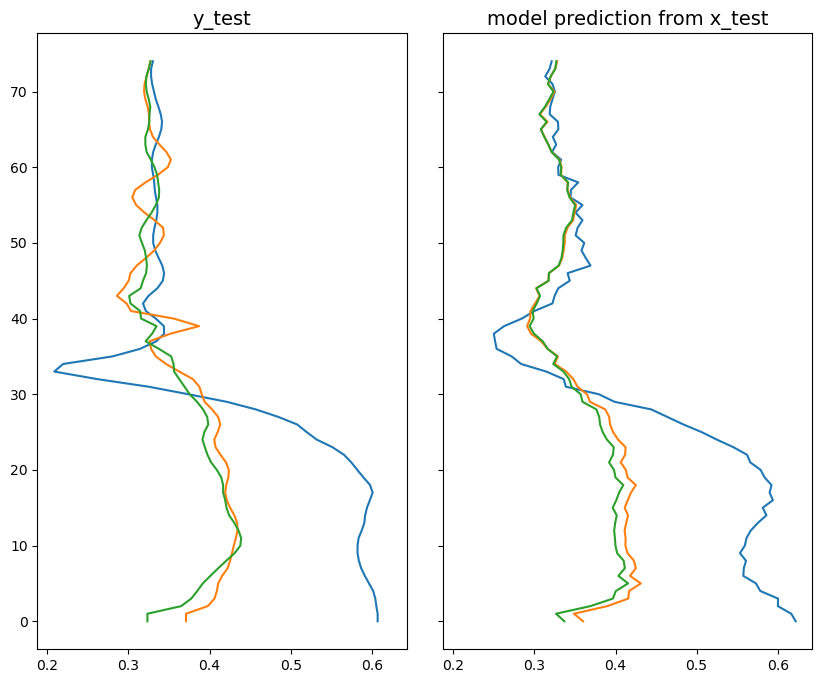

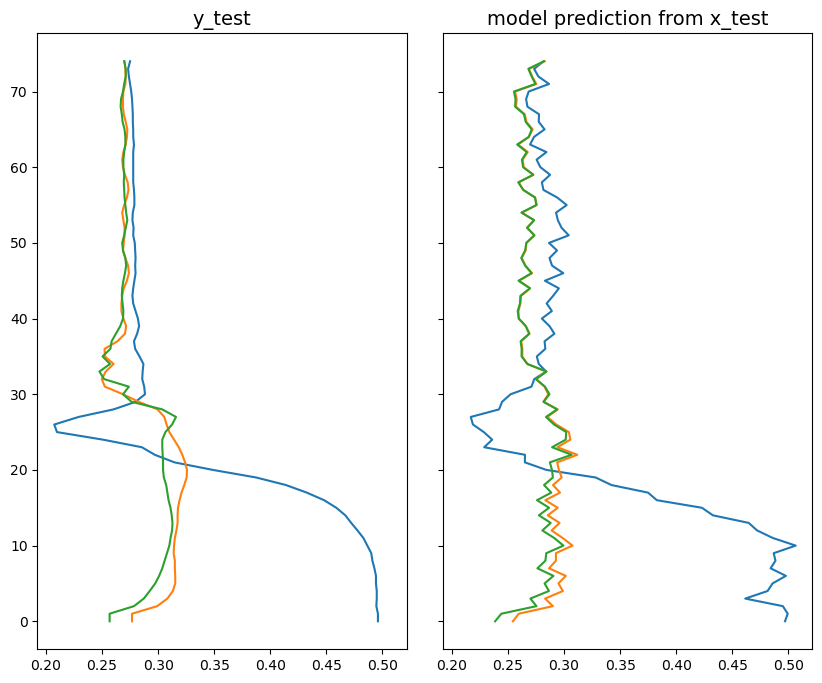

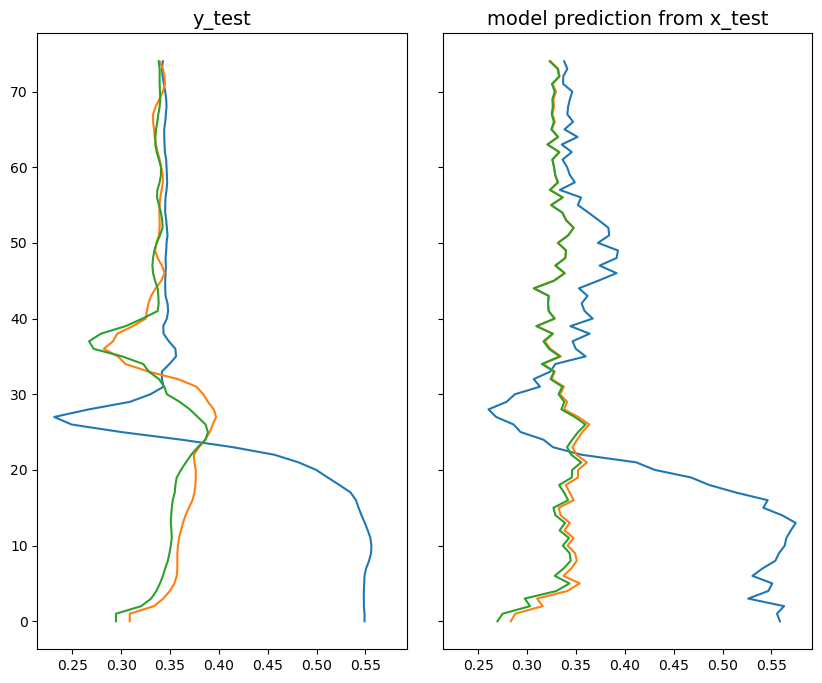

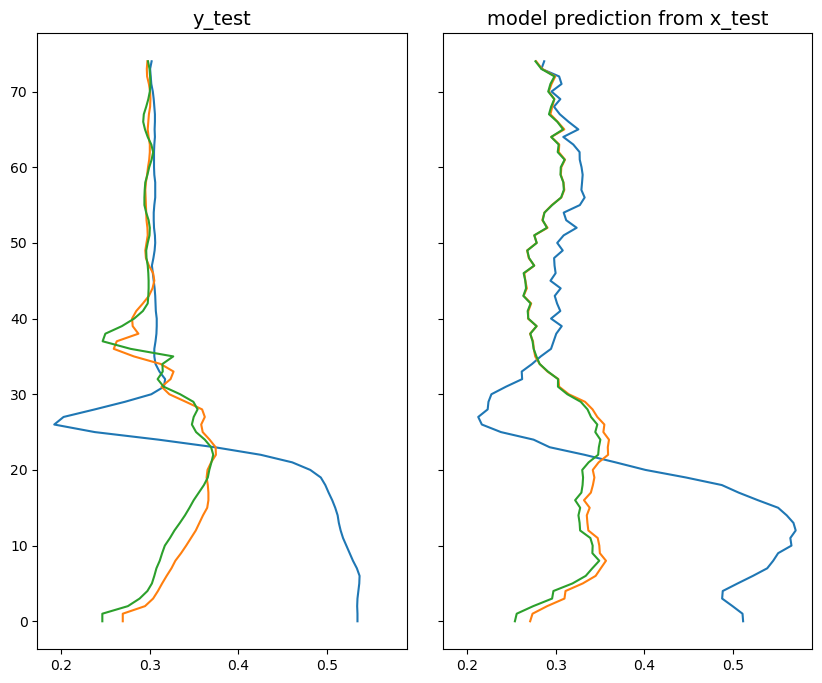

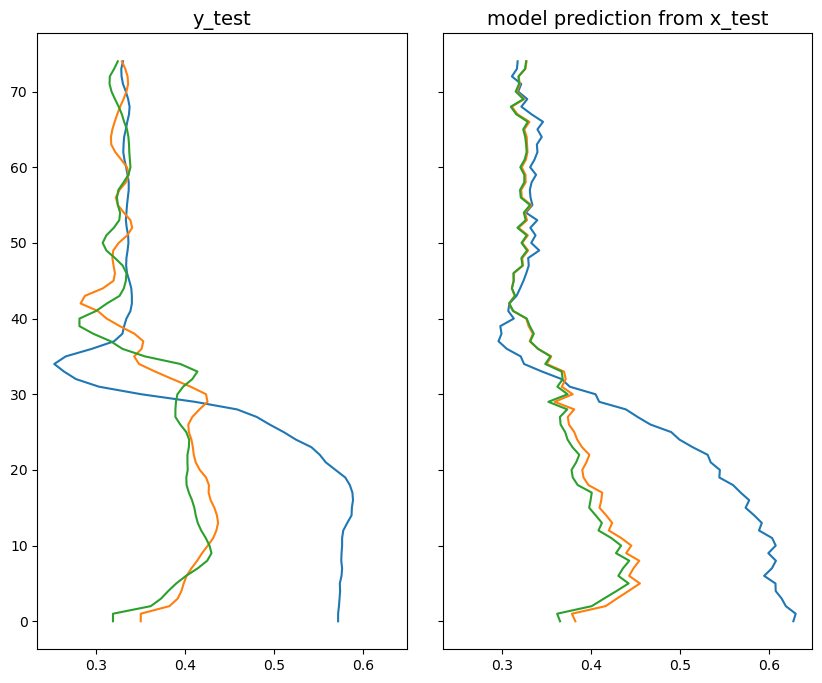

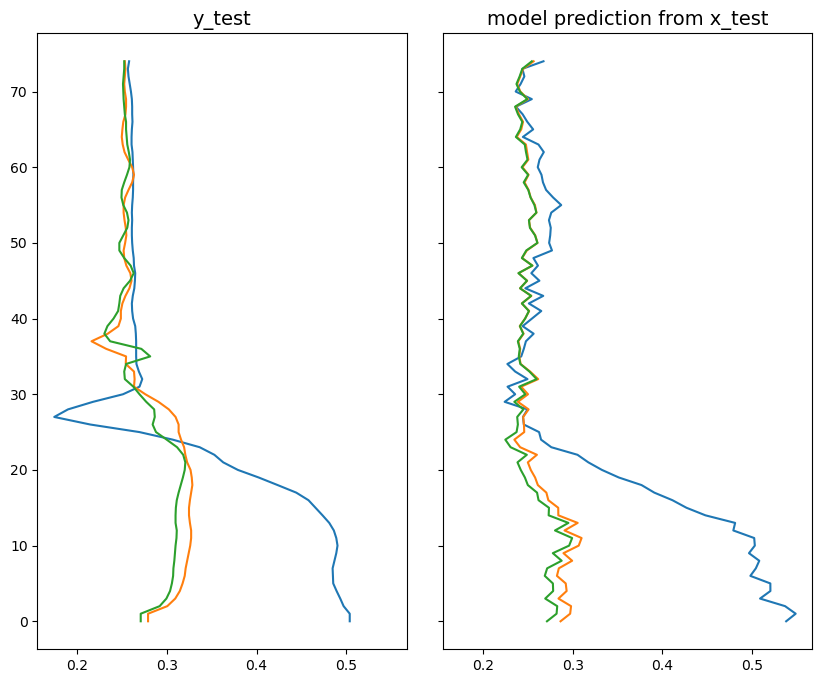

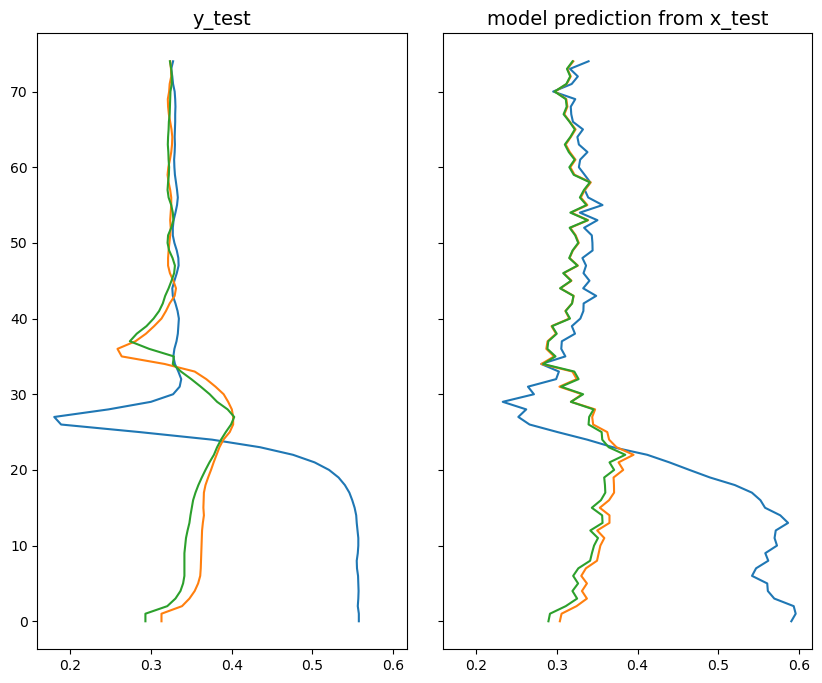

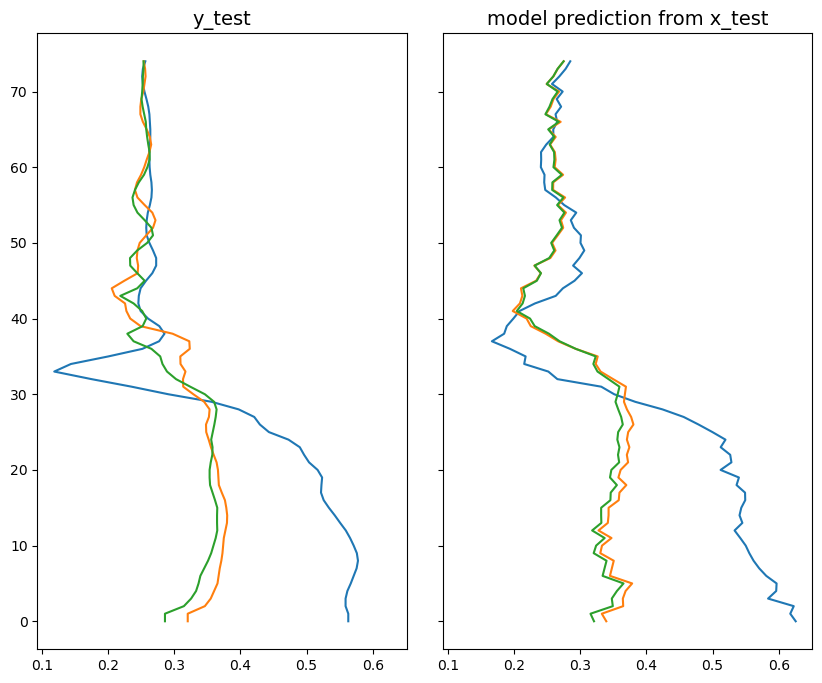

In [23]:
for lu in lu_list:
    lu_data_dict = np.load(f'/home/ch995334/2024ClDyn/TemporaryData/ModelData/all_lu_cnn1/{lu}.npy', allow_pickle=True).item()
    lu_ytest= lu_data_dict['TargetTest']
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 8), gridspec_kw={'wspace':0.1})
    ax[0].plot(lu_ytest[10, :], np.arange(75))
    ax[0].plot(lu_ytest[15, :], np.arange(75))
    ax[0].plot(lu_ytest[30, :], np.arange(75))
    ax[0].set_title('y_test', fontsize=14)
    
    ax[1].plot(nn_dict_all_lu[lu]['prediction'][10, :], np.arange(75))
    ax[1].plot(nn_dict_all_lu[lu]['prediction'][15, :], np.arange(75))
    ax[1].plot(nn_dict_all_lu[lu]['prediction'][30, :], np.arange(75))
    ax[1].set_title('model prediction from x_test', fontsize=14)

Text(0.5, 1.0, 'model prediction from x_test')

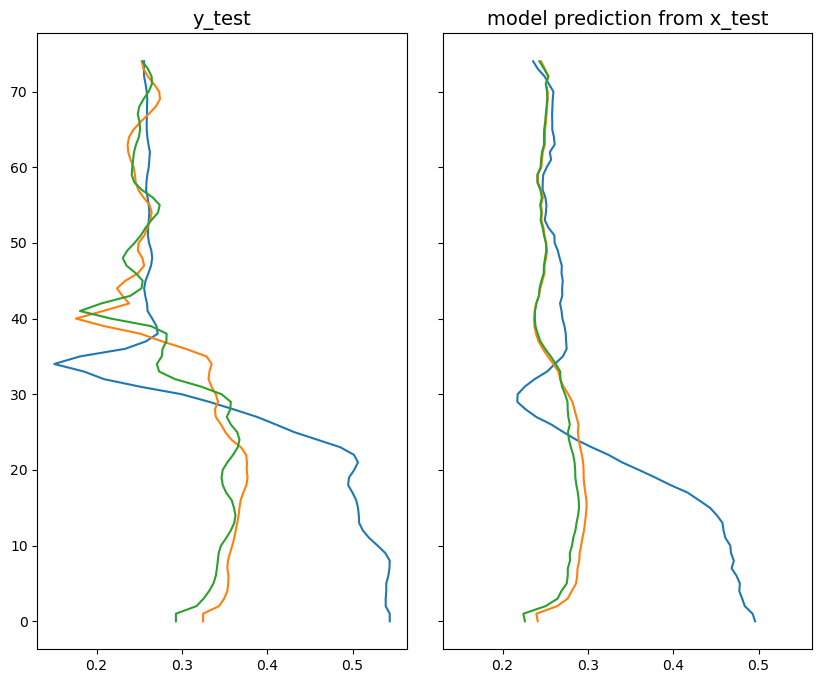

In [97]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 8), gridspec_kw={'wspace':0.1})
ax[0].plot(bu_ytest[10, :], np.arange(75))
ax[0].plot(bu_ytest[15, :], np.arange(75))
ax[0].plot(bu_ytest[30, :], np.arange(75))
ax[0].set_title('y_test', fontsize=14)

ax[1].plot(bu_pred[10, :], np.arange(75))
ax[1].plot(bu_pred[15, :], np.arange(75))
ax[1].plot(bu_pred[30, :], np.arange(75))
ax[1].set_title('model prediction from x_test', fontsize=14)